In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from statsmodels.stats.outliers_influence import OLSInfluence

import statsmodels.api as sm

import matplotlib.pyplot as plt

In [48]:
# Create dataframe and test/train splits of the original data w/ outliers.
DATA_PATH = "usina_with_outliers.csv"
df = pd.read_csv(DATA_PATH)

X = df.drop("PE", axis=1)
y = df["PE"]

X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Q 1.1:**
I chose linear regression because Cook's Distance is defined within the OLS framework. Ridge and lasso modify coefficients based on penalty terms, which makes Cook's Distance less interpretable. 

I chose Statsmodel OLS because it provides native, built-in influence diagnostics which includes Cook's Distance. These diagnostics are computed directly from the fitted OLS without requiring manual implementation. 

In [21]:
# Add intercept for OLS
X_train_sm = sm.add_constant(X_train)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Compute Cook's Distance
influence = OLSInfluence(ols_model)
cooks_d = influence.cooks_distance[0]

# Cook's Distance threshold
n = X_train_sm.shape[0]
threshold = 4 / n

# Identify outliers
outliers = cooks_d > threshold

# Number of detected outliers
num_outliers = outliers.sum()
print(f"Number of outliers detected: {num_outliers}")

# Remove outliers from training data
X_train_clean = X_train.loc[~outliers]
y_train_clean = y_train.loc[~outliers]

# Reconstruct cleaned full dataset (train only, as influence is defined on fitted data)
df_clean = pd.concat([X_train_clean, y_train_clean], axis=1)

# Export cleaned dataset
df_clean.to_csv("usina.csv", index=False)

Number of outliers detected: 85


In [30]:
def evaluate_ridge_lasso_lambdas(X_train, X_test, y_train, y_test):
    lambdas = [0.01, 0.1, 1, 10, 100]
    results = []

    for lam in lambdas:
        # Ridge
        ridge = Ridge(alpha=lam)
        ridge.fit(X_train, y_train)

        y_train_pred = ridge.predict(X_train)
        y_test_pred = ridge.predict(X_test)

        results.append({
            "Model": "Ridge",
            "Lambda": lam,
            "Train MAE": mean_absolute_error(y_train, y_train_pred),
            "Train MSE": mean_squared_error(y_train, y_train_pred),
            "Train R2": r2_score(y_train, y_train_pred),
            "Test MAE": mean_absolute_error(y_test, y_test_pred),
            "Test MSE": mean_squared_error(y_test, y_test_pred),
            "Test R2": r2_score(y_test, y_test_pred),
        })

        # Lasso
        lasso = Lasso(alpha=lam, max_iter=10000)
        lasso.fit(X_train, y_train)

        y_train_pred = lasso.predict(X_train)
        y_test_pred = lasso.predict(X_test)

        results.append({
            "Model": "Lasso",
            "Lambda": lam,
            "Train MAE": mean_absolute_error(y_train, y_train_pred),
            "Train MSE": mean_squared_error(y_train, y_train_pred),
            "Train R2": r2_score(y_train, y_train_pred),
            "Test MAE": mean_absolute_error(y_test, y_test_pred),
            "Test MSE": mean_squared_error(y_test, y_test_pred),
            "Test R2": r2_score(y_test, y_test_pred),
        })

    return pd.DataFrame(results)



In [36]:
#Usina with outliers
df_outliers = pd.read_csv("usina_with_outliers.csv")

X = df_outliers.drop("PE", axis=1)
y = df_outliers["PE"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

ridge_lasso_outliers = evaluate_ridge_lasso_lambdas(
    X_train, X_test, y_train, y_test
)

print("Usina with outliers:")
ridge_lasso_outliers

Usina with outliers:


,Model,Lambda,Train MAE,Train MSE,Train R2,Test MAE,Test MSE,Test R2
0,Ridge,0.01,5.198679,123.384207,0.650171,5.052458,125.113389,0.642574
1,Lasso,0.01,5.198858,123.384210,0.650171,5.052626,125.115332,0.642568
2,Ridge,0.10,5.198680,123.384207,0.650171,5.052459,125.113392,0.642574
3,Lasso,0.10,5.201739,123.384607,0.650169,5.055348,125.134495,0.642514
4,Ridge,1.00,5.198685,123.384207,0.650171,5.052463,125.113421,0.642574
5,Lasso,1.00,5.229507,123.421151,0.650066,5.083092,125.338356,0.641931
6,Ridge,10.00,5.198737,123.384207,0.650171,5.052513,125.113705,0.642573
7,Lasso,10.00,5.540418,126.141514,0.642353,5.408803,128.902136,0.631750
8,Ridge,100.00,5.199261,123.384213,0.650171,5.053003,125.116548,0.642565
9,Lasso,100.00,11.285489,234.655937,0.334683,11.258653,233.064336,0.334178


In [38]:
#Usina without outliers
df_clean = pd.read_csv("usina.csv")

X = df_clean.drop("PE", axis=1)
y = df_clean["PE"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

ridge_lasso_clean = evaluate_ridge_lasso_lambdas(
    X_train, X_test, y_train, y_test
)

print("Usina without outliers:")
ridge_lasso_clean

Usina without outliers:


,Model,Lambda,Train MAE,Train MSE,Train R2,Test MAE,Test MSE,Test R2
0,Ridge,0.01,3.571171,19.453496,0.933362,3.618280,20.166718,0.928319
1,Lasso,0.01,3.571139,19.453500,0.933362,3.618290,20.166881,0.928319
2,Ridge,0.10,3.571171,19.453496,0.933362,3.618281,20.166724,0.928319
3,Lasso,0.10,3.571544,19.454078,0.933360,3.619849,20.176764,0.928283
4,Ridge,1.00,3.571175,19.453496,0.933362,3.618289,20.166776,0.928319
5,Lasso,1.00,3.580046,19.518117,0.933140,3.640196,20.332249,0.927731
6,Ridge,10.00,3.571211,19.453498,0.933362,3.618377,20.167304,0.928317
7,Lasso,10.00,4.040358,25.054273,0.914176,4.181254,26.558771,0.905599
8,Ridge,100.00,3.571594,19.453674,0.933361,3.619265,20.172730,0.928298
9,Lasso,100.00,9.486983,131.895679,0.548190,9.324437,127.911543,0.545350


**Q 2 discussion:** Outliers affect the train and test errors, so when the outliers are removed, both the error decreases and the R^2 improves for both train and test sets. Both of the datasets show similar generalization, but the dataset without the outliers performed better. The test set without the outliers has R^2 values ranging from 0.928319-0.54350. The test set with outliers had R^2 values from 0.64257-0.334178. This shows that the set without outliers performed better. Overall linear regression, ridge, and lasso performed similarly. Ridge and Lasso did not really outperform linear regression. Lasso coefficients changed more dramatically as lambda increased. 

**Q 3.1**
I chose linear regression because the objective of the question is coefficient reliability, which are defined and interpreted in an OLS framework. Ridge and Lasso shrink coefficients, which biases estimates and make standard errors uninterpretable. This makes ridge and lasso not suitable for assessing coefficient reliability. 

I chose Statsmodels OLS because it provides coefficient estimates, t-statistics, p-values, which are needed for evaluating coefficient reliability. 

I didnt scale either the independent or dependent variables, because scaling changes the units and magnitude of the coefficients, which directly affects standard errors and makes intterpretation less intuitive. 

In [44]:
X_sm = sm.add_constant(X)

#Fit model
ols_model = sm.OLS(y, X_sm).fit()

#Create results dataframe of coefficients. 
results_df = pd.DataFrame({
    "Coefficient": ols_model.params,
    "t_value": ols_model.tvalues,
    "p_value": ols_model.pvalues
})

results_df = results_df.reindex(results_df["t_value"].abs().sort_values(ascending=False).index)

display(results_df)

most_reliable = results_df.iloc[0]  # largest absolute t-value
least_reliable = results_df.iloc[-1]  # smallest absolute t-value

print("Most reliable coefficient:")
display(most_reliable)

print("Least reliable coefficient:")
display(least_reliable)

,Coefficient,t_value,p_value
AT,-1.988225,-111.006977,0.000000e+00
const,453.125631,39.594467,7.585330e-308
RH,-0.152825,-32.021180,2.811074e-209
V,-0.230531,-27.146431,6.027900e-154
AP,0.063211,5.688859,1.333659e-08


Most reliable coefficient:


Coefficient     -1.988225
t_value       -111.006977
p_value          0.000000
Name: AT, dtype: float64

Least reliable coefficient:


Coefficient    6.321096e-02
t_value        5.688859e+00
p_value        1.333659e-08
Name: AP, dtype: float64

**Q 4.1:** 
I chose lasso regression because it is designed for feature importance and feature selection. Lasso applies an L1 penalty that shrinks the coefficients to zero, which makes it suited for identifying the most and least important features.

I chose the Scikit-learn library because it provides a stable and efficient lasso implementation, and supports easy experimentation with multiple alpha values.

I would scale the independent variables, because lasso penalizes coefficients based on the magnitude. If the coefficients are on different scales than when they have larger units they get larger penalities. Feature importance becomes biased by scale rather than contribution. 

In [52]:
lambdas = [0.01, 0.1, 1, 10, 100]
results = []

for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)

    y_test_pred = lasso.predict(X_test_scaled)
    r2 = r2_score(y_test, y_test_pred)

    results.append({"Lambda": lam, "Test R2": r2})

results_df = pd.DataFrame(results)
results_df
best_lambda = results_df.loc[results_df["Test R2"].idxmax(), "Lambda"]
best_lambda

print("Best lambda (alpha):", best_lambda)

final_lasso = Lasso(alpha=best_lambda, max_iter=10000)
final_lasso.fit(X_train_scaled, y_train)

coefficients = pd.Series(final_lasso.coef_, index=X.columns)

most_important = coefficients.abs().idxmax()
least_important = coefficients.abs().idxmin()

print("Coefficients:\n", coefficients)
print("\nMost important feature:", most_important)
print("Least important feature:", least_important)


Best lambda (alpha): 0.1
Coefficients:
 AT   -9.023408
V    -5.851011
AP    2.675744
RH   -0.000000
dtype: float64

Most important feature: AT
Least important feature: RH


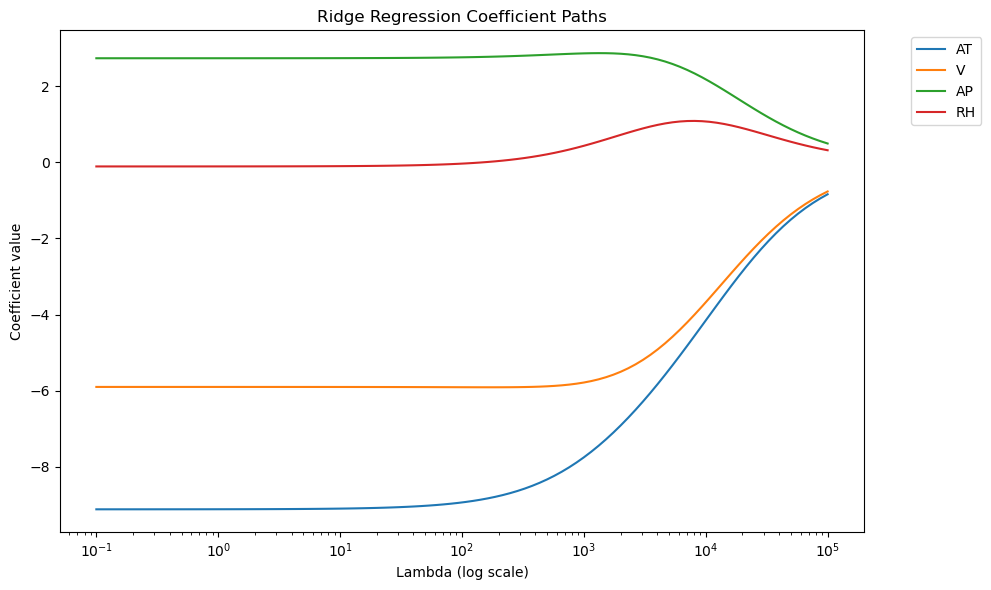

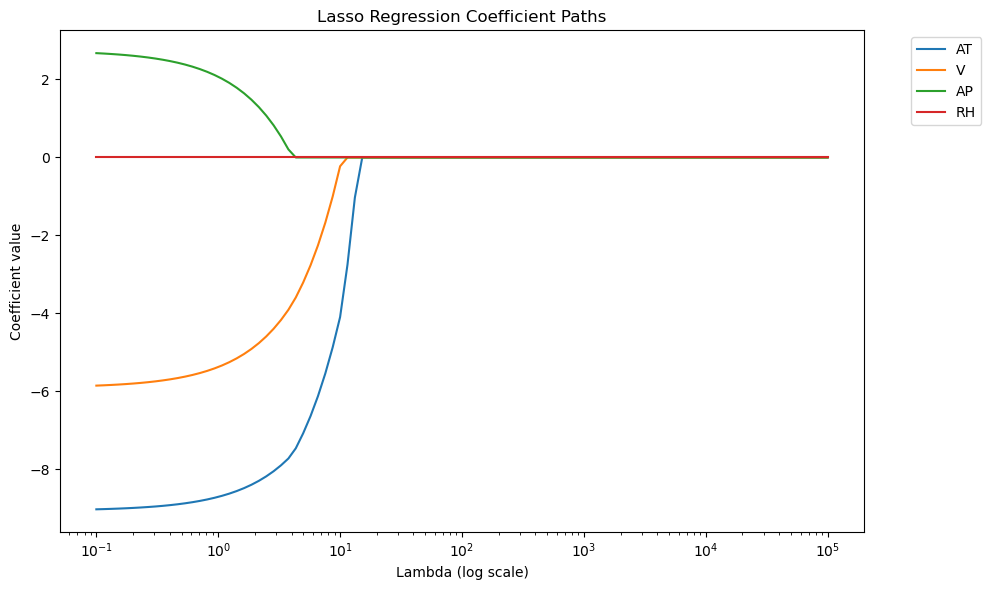

In [57]:
lambdas = np.logspace(-1, 5, 100)  # 0.001 → 1000
ridge_coefs = []

for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = []

for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)

#plots
plt.figure(figsize=(10, 6))
for i, feature in enumerate(X.columns):
    plt.plot(lambdas, ridge_coefs[:, i], label=feature)

plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge Regression Coefficient Paths")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
for i, feature in enumerate(X.columns):
    plt.plot(lambdas, lasso_coefs[:, i], label=feature)

plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Coefficient value")
plt.title("Lasso Regression Coefficient Paths")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


**Q.5 Discussion:**  For ridge, the coefficents converges towards zero. The RH coefficent starts at zero, and then goes up, and then back down to converges to zero. All the coefficients seem to converge at the same time, regardless of coefficient value. In Lasso, all the coefficients go to zero as lambda increases. This happens much faster for lasso than for ridge. They do this at different lambda sizes, with the RH coefficient being at zero the entire time. 

Ridge regression is well suited for handling multicollinearity because it shrinks coefficients of correlated predictors together, rather than eliminating any single variable. This allows all correlated features to remain in the model while reducing variance and stabilizing coefficient estimates.

In contrast, Lasso regression tends to select one variable from a group of correlated predictors and shrink the remaining coefficients to zero. This behavior can be less stable in the presence of strong correlations among independent variables, as small changes in the data may lead to different variables being selected.

Lasso is particularly effective for feature selection, as its L1 penalty enforces sparsity by shrinking less important coefficients exactly to zero. As a result, only the most influential predictors remain in the model, improving interpretability.